- 1. 데이터셋 확인
    - 1.1 Null data check
    - 1.2 target label 확인
    

- 2. EDA
    - 2.1 time
    - 2.2 player
    - 2.3 species
    - 2.4 event & event_contents

In [1]:
# 패키지 불러오기

import pandas as pd                         # 데이터 분석 라이브러리
import numpy as np                          # 계산 라이브러리
from tqdm import tqdm                       # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.model_selection import KFold   # K-fold CV    
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings                             
warnings.filterwarnings("ignore")           # 경고 문구 미표시

In [3]:
train = pd.read_csv('data/train.csv')

In [4]:
test = pd.read_csv('data/test.csv')

In [4]:
df_train.head()

,game_id,winner,time,player,species,event,event_contents
0,0,1,0.00,0,T,Camera,"at (145.25, 21.5078125)"
1,0,1,0.00,1,T,Camera,"at (22.75, 147.0078125)"
2,0,1,0.02,0,T,Selection,['OrbitalCommand [3080001]']
3,0,1,0.02,0,T,Ability,(1360) - TrainSCV
4,0,1,0.14,0,T,Camera,"at (142.99609375, 24.50390625)"


In [6]:
df_train[df_train['game_id'] == 10000]

,game_id,winner,time,player,species,event,event_contents
17279403,10000,1,0.00,0,T,Camera,"at (28.0, 18.5078125)"
17279404,10000,1,0.00,1,Z,Camera,"at (140.0, 162.0078125)"
17279405,10000,1,0.01,1,Z,Selection,['Hive [3340001]']
17279406,10000,1,0.01,1,Z,Selection,"['Egg [3380001]', 'Egg [33C0001]', 'Egg [34000..."
17279407,10000,1,0.01,1,Z,Ability,(1820) - MorphDrone
...,...,...,...,...,...,...,...
17282260,10000,1,9.59,1,Z,GetControlGroup,NaN
17282261,10000,1,9.59,0,T,Ability,(1360) - TrainSCV
17282262,10000,1,9.59,1,Z,GetControlGroup,NaN
17282263,10000,1,9.59,1,Z,GetControlGroup,NaN


In [8]:
df_small = df_train.iloc[:17282264]
df_small

,game_id,winner,time,player,species,event,event_contents
0,0,1,0.00,0,T,Camera,"at (145.25, 21.5078125)"
1,0,1,0.00,1,T,Camera,"at (22.75, 147.0078125)"
2,0,1,0.02,0,T,Selection,['OrbitalCommand [3080001]']
3,0,1,0.02,0,T,Ability,(1360) - TrainSCV
4,0,1,0.14,0,T,Camera,"at (142.99609375, 24.50390625)"
...,...,...,...,...,...,...,...
17282259,10000,1,9.58,0,T,Right Click,"Target: None [026C0001]; Location: (67.0, 14.5..."
17282260,10000,1,9.59,1,Z,GetControlGroup,NaN
17282261,10000,1,9.59,0,T,Ability,(1360) - TrainSCV
17282262,10000,1,9.59,1,Z,GetControlGroup,NaN


In [9]:
df_small.to_pickle('train_17m.pickle')

In [4]:
# 데이터셋 확인
df_train.shape # 6700만

(67091776, 7)

In [5]:
# feature type 확인
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67091776 entries, 0 to 67091775
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   game_id         int64  
 1   winner          int64  
 2   time            float64
 3   player          int64  
 4   species         object 
 5   event           object 
 6   event_contents  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 3.5+ GB


# 변수 설명

game_id : 경기 구분 기호

winner : 승리 선수 --> 한 게임에서 0과 1이라는 플레이어가 있는데 둘 중 누가 이긴지를 의미함

time : 경기 시간

player : 선수

##1) 0: 첫 번째 선수

##2) 1: 두 번째 선수

species : 종족

##1) T: 테란

##2) P: 프로토스

##3) Z: 저그

event : 행동 종류

event_contents : 행동 상세

##1) Ability : 생산, 공격 등 선수의 주요 행동

##2) AddToControlGroup : 부대에 추가

##3) Camera : 시점 선택

##4) ControlGroup : 부대 행동

##5) GetControlGroup : 부대 불러오기

##6) Right Click : 마우스 우클릭

##7) Selection : 객체 선택

##8) SetControlGroup : 부대 지정

In [5]:
pd.options.display.float_format = '{:.2f}'.format # 소수점 둘째자리까지 표현

# 연속형, 이산형 데이터의 기술적 통계
df_train.describe() 

NameError: name 'df_train' is not defined

time이 11분을 넘지 않는 것으로 보아, 데이터의 크기를 고려해서 11분 미만으로 컷 한것 같음.

In [ ]:
# 결측값 확인
train.isna().sum().to_frame() 

event_contents에 대한 NaN값이 굉장히 많다. 

해당 내용은 event와 연관되기 때문에 NaN값을 갖는 event값들을 찾아보자

In [8]:
df_train.loc[df_train['event_contents'].isna()]['event'].value_counts()

GetControlGroup      10051180
SetControlGroup        340704
AddToControlGroup      149340
ControlGroup            30719
Name: event, dtype: int64

##5) GetControlGroup : 부대 불러오기
    
    --> 지정해놓은 부대를 다시 불러오는 개념: 이전에 컨트롤+1로 마린 부대를 지정했을 경우, 1을 누르면 마린부대를 불러올 수 있다.
    

##8) SetControlGroup : 부대 지정

    --> 컨트롤 + 숫자 를 통해서 새로운 부대를 지정할 수 있다. 
    

##2) AddToControlGroup : 부대에 추가
    
    --> 지정된 부대 (예를 들면 1번) 을 눌러서 쉬프트 + 드래그 or 클릭 을 통해 부대에 추가할 수 있다.
    

##4) ControlGroup : 부대 행동
    
    --> 1(부대지정)을 누른 상태에서 해당 부대를 이동시키거나 공격시키는 행위(홀드나 패트롤도 포함일듯)

In [9]:
# 부대 불러오기 변수는 모두 NaN일까?
GCG_nan = df_train.loc[df_train['event']=='GetControlGroup', 'event_contents']
GCG_nan.value_counts()

Series([], Name: event_contents, dtype: int64)

In [10]:
# 부대 지정 변수
SCG_nan = df_train.loc[df_train['event']=='SetControlGroup', 'event_contents']
SCG_nan.value_counts()

Series([], Name: event_contents, dtype: int64)

In [11]:
# 부대에 추가 변수
ATCG_nan = df_train.loc[df_train['event']=='AddToControlGroup', 'event_contents']
ATCG_nan.value_counts()

Series([], Name: event_contents, dtype: int64)

In [12]:
# 부대 행동 변수
CG_nan = df_train.loc[df_train['event']=='ControlGroup', 'event_contents']
CG_nan.value_counts()

Series([], Name: event_contents, dtype: int64)

In [13]:
def value_counts(col):
    print(df_train[col].value_counts())

df_train['event'].value_counts().to_frame()

,event
Camera,31629407
Right Click,11565877
GetControlGroup,10051180
Selection,9526159
Ability,3798390
SetControlGroup,340704
AddToControlGroup,149340
ControlGroup,30719


##3) Camera : 시점 선택

    --> 1초 안에 화면을 밀거나 하는 행위는 0.x초 단위로 데이터가 추가되지 않은 것 같음. 화면을 조금만 밀더라도 동일한 초 내에는 중복으로 처리

##6) Right Click : 마우스 우클릭

*##5) GetControlGroup : 부대 불러오기(위에 설명)*

##7) Selection : 객체 선택

##1) Ability : 생산, 공격 등 선수의 주요 행동

*##8) SetControlGroup : 부대 지정(위에 설명)*

*##2) AddToControlGroup : 부대에 추가(위에 설명)*

*##4) ControlGroup : 부대 행동(위에 설명)*

'부대' 관련된 변수는 모두 NaN값을 가진다.

각 행동별로 분류가 추가적으로 되면 너무 많은 데이터셋이므로 일관성있게 데이터를 추가하지 않은 것으로 보임

## 최대 게임시간이 2분 미만인 경우
게임이 정상적으로 완료되지 않을 확률이 높다. (탈주, 튕김 등)

In [15]:
df_time = df_train.groupby('game_id')['time'].max()

In [17]:
# 2분 미만의 게임한 game_id 추출
df_time[df_time < 2]

game_id
88      1.02
143     1.33
182     1.57
187     0.30
200     0.08
        ... 
38746   0.46
38778   0.25
38827   1.51
38865   0.39
38866   0.37
Name: time, Length: 1041, dtype: float64

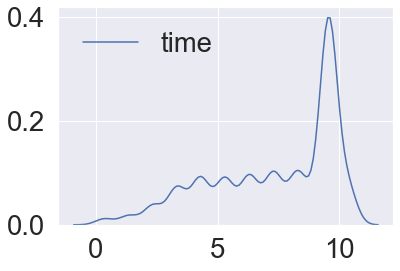

In [16]:
sns.kdeplot(df_time)
plt.show()

In [18]:
# 1분 57초 게임의 예시
df_train.loc[df_train['game_id']==182].head(10)

,game_id,winner,time,player,species,event,event_contents
294790,182,1,0.00,0,T,Camera,"at (145.25, 21.5078125)"
294791,182,1,0.00,1,T,Camera,"at (22.75, 147.0078125)"
294792,182,1,0.01,1,T,Selection,['CommandCenter [33C0001]']
294793,182,1,0.01,1,T,Ability,(1360) - TrainSCV
294794,182,1,0.01,1,T,Selection,"['SCV [3640001]', 'SCV [36C0001]']"
294795,182,1,0.01,1,T,Right Click,"Target: None [00A80001]; Location: (18.0, 147...."
294796,182,1,0.02,0,T,Right Click,"Location: (142.105712890625, 19.527099609375, ..."
294797,182,1,0.02,0,T,Camera,"at (146.50390625, 22.37890625)"
294798,182,1,0.02,1,T,Selection,['CommandCenter [33C0001]']
294799,182,1,0.03,0,T,Right Click,"Location: (17.689208984375, 148.279052734375, ..."


총 1041번의 게임이 2분 미만의 게임으로 끝남

## 카메라 시점**

In [48]:
# 패턴으로 x축 y축만 리스트로 추출
import re

def get_vector(tokken):
    pattern = '\d*[.]\d*'
    pat = re.compile(pattern)
    result = pat.findall(str(tokken))
    result = [float(i) for i in result]
    return np.array(result, dtype=np.float32)

In [55]:
df_train.loc[df_train['game_id']==4].head(2)

,game_id,winner,time,player,species,event,event_contents
8807,4,0,0.00,1,Z,Camera,"[163.25, 18.507812]"
8808,4,0,0.00,0,T,Camera,"[36.75, 122.00781]"


In [59]:
df_train.loc[(df_train['game_id']==4) & (df_train['event'] == 'Camera')].tail(20)

,game_id,winner,time,player,species,event,event_contents
10372,4,0,5.32,0,T,Camera,"[49.148438, 115.74219]"
10377,4,0,5.33,0,T,Camera,"[43.683594, 120.75781]"
10380,4,0,5.33,0,T,Camera,"[43.683594, 122.89844]"
10385,4,0,5.34,0,T,Camera,"[44.921875, 122.89844]"
10386,4,0,5.34,1,Z,Camera,"[161.5, 19.757812]"
10387,4,0,5.34,0,T,Camera,"[50.38672, 122.89844]"
10390,4,0,5.35,1,Z,Camera,"[157.5, 48.757812]"
10394,4,0,5.36,1,Z,Camera,"[161.5, 19.757812]"
10399,4,0,5.37,0,T,Camera,"[51.679688, 120.8125]"
10400,4,0,5.37,0,T,Camera,"[54.160156, 117.71484]"


In [31]:
df_camera = df_train.loc[(df_train['event']=='Camera')]

In [60]:
df_camera

,game_id,winner,time,player,species,event,event_contents
0,0,1,0.00,0,T,Camera,"[145.25, 21.507812]"
1,0,1,0.00,1,T,Camera,"[22.75, 147.00781]"
4,0,1,0.14,0,T,Camera,"[142.9961, 24.503906]"
5,0,1,0.14,0,T,Camera,"[142.50781, 24.988281]"
6,0,1,0.14,0,T,Camera,"[139.61719, 27.882812]"
...,...,...,...,...,...,...,...
67091769,38871,0,8.51,1,T,Camera,"[51.039062, 115.51172]"
67091770,38871,0,8.51,1,T,Camera,"[51.039062, 116.61328]"
67091771,38871,0,8.51,0,Z,Camera,"[139.57812, 62.58203]"
67091773,38871,0,8.52,0,Z,Camera,"[122.42578, 45.429688]"


In [49]:
df_camera['event_contents'] = df_camera['event_contents'].apply(get_vector)
df_train[df_train['event'] == 'Camera'] = df_camera

In [53]:
df_train.head()

,game_id,winner,time,player,species,event,event_contents
0,0,1,0.00,0,T,Camera,"[145.25, 21.507812]"
1,0,1,0.00,1,T,Camera,"[22.75, 147.00781]"
2,0,1,0.02,0,T,Selection,['OrbitalCommand [3080001]']
3,0,1,0.02,0,T,Ability,(1360) - TrainSCV
4,0,1,0.14,0,T,Camera,"[142.9961, 24.503906]"


## Ability

In [21]:
df_train.loc[[10427]]

,game_id,winner,time,player,species,event,event_contents
10427,5,0,0.01,1,P,Ability,(15E0) - TrainProbe


In [22]:
# Ability값만 추출 (하나의 게임)
df_train.loc[(df_train['game_id']==5) & (df_train['event']=='Ability')].head(50)

,game_id,winner,time,player,species,event,event_contents
10427,5,0,0.01,1,P,Ability,(15E0) - TrainProbe
10429,5,0,0.02,0,P,Ability,(15E0) - TrainProbe
10454,5,0,0.12,1,P,Ability,(15E0) - TrainProbe
10474,5,0,0.26,1,P,Ability,"(1541) - BuildPylon; Location: (137.0, 35.0, 4..."
10509,5,0,0.33,1,P,Ability,(15E0) - TrainProbe
10517,5,0,0.37,1,P,Ability,(15E0) - TrainProbe
10523,5,0,0.40,0,P,Ability,"(1541) - BuildPylon; Location: (32.0, 117.0, 4..."
10544,5,0,0.53,0,P,Ability,(5A0) - Attack; Target: None [02040001]; Locat...
10546,5,0,0.55,1,P,Ability,"(1543) - BuildGateway; Location: (138.5, 37.5,..."
10576,5,0,1.15,1,P,Ability,"(1541) - BuildPylon; Location: (141.0, 28.0, 4..."


In [23]:
# 한 게임에서의 Ability가 되는 유니크한 값들
# 일꾼이나 오버로드, 건물 건설은 나타나지만 공격 유닛 생산은 나타나지 않음
# 전투에서 얼마나 살고 죽었는지 알 수 없음


df_train.loc[(df_train['game_id']==2) & (df_train['event']=='Ability')]['event_contents'].unique()

array(['(15E0) - TrainProbe', '(1820) - MorphDrone',
       '(1541) - BuildPylon; Location: (146.0, 47.0, 40941)',
       '(1543) - BuildGateway; Location: (140.5, 47.5, 40931)',
       '(4C1) - Patrol; Location: (21.416015625, 106.96533203125, 40940)',
       '(1542) - BuildAssimilator; Target: DestructibleSignsFunny [007C0001]; Location: (156.5, 26.5, 49136)',
       '(16E3) - BuildSpawningPool; Location: (28.5, 124.5, 49134)',
       '(1822) - MorphOverlord',
       '(1542) - BuildAssimilator; Target: DestructibleSignsFunny [00780001]; Location: (146.5, 16.5, 49128)',
       '(1541) - BuildPylon; Location: (151.0, 27.0, 49137)',
       '(1E60) - TrainQueen', '(1821) - MorphZergling',
       '(E80) - ChronoBoost; Target: WarpGate [03500002]; Location: (140.5, 47.5, 40932)',
       '(2720) - TrainMothershipCore', '(1581) - TrainStalker',
       '(E80) - ChronoBoost; Target: Nexus [03100001]; Location: (149.5, 23.5, 49120)',
       '(17C1) - EvolveMetabolicBoost', '(1D86) - ResearchWar

In [24]:
#  액션에서 행위의 스트링만 추출

def get_ab(str):
    return str.split()[2]

get_ab('(1541) - BuildPylon; Location: (137.0, 35.0, 4...)')

'BuildPylon;'

위에서 Ability의 패턴을 스플릿으로 나눠서 Attack이나 Build를 추출하려 했으나 

이상한 값으로 인해서 실패

In [25]:
#  전체 데이터셋 중 이상한 Ability 값. 제거 요망

df_train.loc[(df_train['event_contents']=='(127E)')]

,game_id,winner,time,player,species,event,event_contents
113964,71,1,6.44,1,T,Ability,(127E)
264673,165,1,2.11,1,T,Ability,(127E)
451541,267,1,6.23,0,T,Ability,(127E)
518543,305,1,3.50,0,T,Ability,(127E)
526327,309,1,7.05,1,T,Ability,(127E)
...,...,...,...,...,...,...,...
66450208,38495,1,5.24,0,T,Ability,(127E)
66677383,38633,1,5.09,0,T,Ability,(127E)
66695451,38646,0,3.25,1,T,Ability,(127E)
66853770,38732,1,3.50,0,T,Ability,(127E)


38871개의 게임 데이터셋을 의미

# 데이콘 모델

In [6]:
def species_converter(string):
    if string == 'T':
        return 0
    elif string == 'P':
        return 1
    elif string == 'Z':
        return 2
    else:
        raise ValueError

def data_preparation(df, answer=False):
    game_ids = df['game_id'].unique()
    events = ['Ability', 'AddToControlGroup', 'Camera', 'ControlGroup', 'GetControlGroup', 'Right Click', 'Selection', 'SetControlGroup']
    unique_event_0, unique_event_1, delta_event = {}, {}, {}
    for event in events:
        unique_event_0['P0_' + event] = 0
        unique_event_1['P1_' + event] = 0
        delta_event['delta_' + event] = 0
        
    species = df.groupby(['game_id', 'player']).species.unique()
    event_count = df.groupby(['game_id', 'player']).event.value_counts()
    if answer:
        winners = df.groupby(['game_id']).winner.max()
    
    x_data, y_data = [], []
    for game_id in tqdm(game_ids):
        df_event_count = event_count[game_id].unstack(level=-1)
        df = pd.DataFrame(species[game_id])
        df = pd.concat([df, df_event_count], axis=1)   
        df = df.fillna(0)
        
        df_P0_species = pd.DataFrame([species_converter(df.loc[0]['species'][0])], columns=['P0_species'])        
        df_P1_species = pd.DataFrame([species_converter(df.loc[1]['species'][0])], columns=['P1_species'])
        df = df.drop(['species'], axis=1)

        df_P0_event = unique_event_0.copy()
        for column in df.columns:
            df_P0_event['P0_' + column] = df.loc[0][column]
        df_P0_event = pd.DataFrame(pd.Series(df_P0_event)).T

        df_P1_event = unique_event_1.copy()
        for column in df.columns:
            df_P1_event['P1_' + column] = df.loc[1][column]
        df_P1_event = pd.DataFrame(pd.Series(df_P1_event)).T
        
        df_delta_event = delta_event.copy()
        for column in df.columns:
            df_delta_event['delta_' + column] = df_P0_event['P0_' + column][0] - df_P1_event['P1_' + column][0]
        df_delta_event = pd.DataFrame(pd.Series(df_delta_event)).T

        out = pd.concat([df_P0_species, df_P0_event, df_P1_species, df_P1_event, df_delta_event], axis=1)
        out.index = [game_id]
        out.index.name = 'game_id'
        
        x_data.append(out)
        if answer:
            y_data.append(winners[game_id])  

    x_data = pd.concat(x_data)
    y_data = np.array(y_data)
    
    return x_data, y_data

In [12]:
x_train, y_train = data_preparation(train, answer=True)
x_train.head()


  1%|█▏                                                                            | 577/38872 [00:07<07:49, 81.57it/s]


  3%|██▎                                                                          | 1173/38872 [00:14<08:51, 70.99it/s]


  5%|███▌                                                                         | 1792/38872 [00:21<07:21, 84.05it/s]


  6%|████▋                                                                        | 2395/38872 [00:29<07:48, 77.78it/s]


  8%|█████▉                                                                       | 3023/38872 [00:36<07:01, 85.10it/s]


  9%|███████▏                                                                     | 3636/38872 [00:43<08:01, 73.21it/s]


 11%|████████▍                                                                    | 4228/38872 [00:50<07:37, 75.69it/s]


 12%|█████████▌                                                                   | 4835/38872 [00:58<06:46, 83.70it/s]


 14%|██████████▊                                                                  | 5465/38872 [01:05<06:25, 86.63it/s]


 16%|████████████                                                                 | 6062/38872 [01:12<06:32, 83.57it/s]


 17%|█████████████▏                                                               | 6654/38872 [01:20<08:09, 65.83it/s]


 18%|██████████████▏                                                              | 7148/38872 [01:28<07:35, 69.71it/s]


 20%|███████████████▎                                                             | 7751/38872 [01:36<06:14, 82.99it/s]


 22%|████████████████▌                                                            | 8386/38872 [01:43<06:11, 82.12it/s]


 23%|█████████████████▉                                                           | 9041/38872 [01:50<05:32, 89.76it/s]


 25%|███████████████████▏                                                         | 9699/38872 [01:57<05:05, 95.58it/s]


 26%|████████████████████                                                        | 10290/38872 [02:05<06:21, 74.88it/s]


 28%|█████████████████████▎                                                      | 10898/38872 [02:12<05:36, 83.02it/s]


 30%|██████████████████████▌                                                     | 11541/38872 [02:19<05:05, 89.45it/s]


 31%|███████████████████████▊                                                    | 12178/38872 [02:26<04:38, 95.88it/s]


 33%|█████████████████████████                                                   | 12829/38872 [02:34<04:29, 96.60it/s]


 35%|██████████████████████████▏                                                 | 13424/38872 [02:41<05:19, 79.63it/s]


 36%|███████████████████████████▎                                                | 13981/38872 [02:49<05:42, 72.74it/s]


 37%|████████████████████████████▍                                               | 14536/38872 [02:56<05:23, 75.15it/s]


 39%|█████████████████████████████▌                                              | 15117/38872 [03:03<04:38, 85.44it/s]


 40%|██████████████████████████████▋                                             | 15709/38872 [03:11<04:42, 82.06it/s]


 42%|███████████████████████████████▉                                            | 16305/38872 [03:18<04:56, 76.12it/s]


 43%|████████████████████████████████▊                                           | 16806/38872 [03:27<06:32, 56.28it/s]


 45%|█████████████████████████████████▊                                          | 17302/38872 [03:35<05:30, 65.17it/s]


 46%|██████████████████████████████████▊                                         | 17799/38872 [03:43<04:08, 84.71it/s]


 47%|███████████████████████████████████▉                                        | 18352/38872 [03:51<04:10, 82.05it/s]


 48%|████████████████████████████████████▊                                       | 18834/38872 [03:59<06:41, 49.95it/s]


 50%|█████████████████████████████████████▊                                      | 19343/38872 [04:07<04:02, 80.43it/s]


 51%|██████████████████████████████████████▉                                     | 19917/38872 [04:14<04:12, 74.98it/s]


 53%|████████████████████████████████████████                                    | 20491/38872 [04:21<04:02, 75.86it/s]


 54%|█████████████████████████████████████████▏                                  | 21088/38872 [04:29<03:39, 81.07it/s]


 56%|██████████████████████████████████████████▍                                 | 21674/38872 [04:36<03:23, 84.52it/s]


 57%|███████████████████████████████████████████▌                                | 22273/38872 [04:44<03:49, 72.29it/s]


 59%|████████████████████████████████████████████▋                               | 22849/38872 [04:51<03:09, 84.59it/s]


 60%|█████████████████████████████████████████████▊                              | 23437/38872 [04:58<03:53, 66.24it/s]


 62%|██████████████████████████████████████████████▊                             | 23969/38872 [05:06<03:29, 71.13it/s]


 63%|███████████████████████████████████████████████▉                            | 24494/38872 [05:14<02:58, 80.69it/s]


 64%|████████████████████████████████████████████████▊                           | 24944/38872 [05:22<07:46, 29.87it/s]


 65%|█████████████████████████████████████████████████▋                          | 25439/38872 [05:30<04:27, 50.27it/s]


 66%|██████████████████████████████████████████████████▍                         | 25827/38872 [05:39<03:21, 64.60it/s]


 68%|███████████████████████████████████████████████████▌                        | 26358/38872 [05:47<02:53, 72.19it/s]


 69%|████████████████████████████████████████████████████▋                       | 26941/38872 [05:55<02:02, 97.12it/s]


 71%|█████████████████████████████████████████████████████▉                      | 27612/38872 [06:02<01:55, 97.10it/s]


 73%|███████████████████████████████████████████████████████▎                    | 28270/38872 [06:10<02:38, 66.88it/s]


 74%|███████████████████████████████████████████████████████▉                    | 28635/38872 [06:19<08:27, 20.19it/s]


 74%|████████████████████████████████████████████████████████▌                   | 28908/38872 [06:29<03:50, 43.30it/s]


 75%|█████████████████████████████████████████████████████████                   | 29203/38872 [06:38<05:38, 28.57it/s]


 76%|█████████████████████████████████████████████████████████▊                  | 29543/38872 [06:46<03:13, 48.29it/s]


 77%|██████████████████████████████████████████████████████████▋                 | 29986/38872 [06:55<02:00, 73.51it/s]


 79%|███████████████████████████████████████████████████████████▊                | 30593/38872 [07:02<01:32, 89.39it/s]


 80%|████████████████████████████████████████████████████████████▉               | 31177/38872 [07:10<01:32, 83.30it/s]


 82%|██████████████████████████████████████████████████████████████              | 31740/38872 [07:17<01:19, 90.00it/s]


 83%|███████████████████████████████████████████████████████████████▏            | 32344/38872 [07:25<01:24, 77.62it/s]


 85%|████████████████████████████████████████████████████████████████▎           | 32923/38872 [07:32<01:26, 68.69it/s]


 86%|█████████████████████████████████████████████████████████████████▍          | 33475/38872 [07:40<01:05, 81.90it/s]


 88%|██████████████████████████████████████████████████████████████████▌         | 34065/38872 [07:47<01:14, 64.58it/s]


 89%|███████████████████████████████████████████████████████████████████▊        | 34681/38872 [07:54<00:46, 90.45it/s]


 91%|█████████████████████████████████████████████████████████████████████       | 35305/38872 [08:02<00:47, 75.05it/s]


 92%|██████████████████████████████████████████████████████████████████████▏     | 35927/38872 [08:09<00:35, 83.63it/s]


 94%|███████████████████████████████████████████████████████████████████████▍    | 36550/38872 [08:16<00:27, 83.45it/s]


 96%|████████████████████████████████████████████████████████████████████████▋   | 37181/38872 [08:23<00:18, 89.05it/s]


 97%|█████████████████████████████████████████████████████████████████████████▉  | 37794/38872 [08:30<00:11, 91.18it/s]


 99%|███████████████████████████████████████████████████████████████████████████ | 38419/38872 [08:38<00:05, 87.51it/s]


100%|████████████████████████████████████████████████████████████████████████████| 38872/38872 [08:43<00:00, 74.25it/s]


,P0_species,P0_Ability,P0_AddToControlGroup,P0_Camera,P0_ControlGroup,P0_GetControlGroup,P0_Right Click,P0_Selection,P0_SetControlGroup,P1_species,...,P1_Selection,P1_SetControlGroup,delta_Ability,delta_AddToControlGroup,delta_Camera,delta_ControlGroup,delta_GetControlGroup,delta_Right Click,delta_Selection,delta_SetControlGroup
game_id,,,,,,,,,,,,,,,,,,,,,
0,0,34.00,2.00,444.00,0.00,24.00,35.00,50.00,3.00,0,...,57.00,1.00,0.00,2.00,19.00,0.00,21.00,7.00,-7.00,2.00
1,1,77.00,1.00,627.00,0.00,162.00,160.00,186.00,10.00,0,...,116.00,8.00,10.00,1.00,-231.00,0.00,131.00,29.00,70.00,2.00
2,1,69.00,6.00,413.00,0.00,99.00,160.00,90.00,14.00,2,...,232.00,9.00,-16.00,1.00,-312.00,-2.00,-10.00,-44.00,-142.00,5.00
3,0,82.00,0.00,713.00,0.00,132.00,276.00,180.00,6.00,1,...,148.00,19.00,-7.00,0.00,325.00,0.00,-578.00,8.00,32.00,-13.00
4,0,57.00,1.00,430.00,0.00,224.00,177.00,67.00,10.00,2,...,126.00,8.00,21.00,-3.00,158.00,0.00,125.00,71.00,-59.00,2.00


# APM 1 or 0

In [38]:

x_test, _ = data_preparation(test, answer=False)


  3%|██▍                                                                           | 537/16787 [00:07<03:50, 70.48it/s]


  6%|████▊                                                                        | 1041/16787 [00:15<04:37, 56.68it/s]


  9%|███████▏                                                                     | 1573/16787 [00:23<03:17, 76.93it/s]


 13%|█████████▋                                                                   | 2110/16787 [00:31<09:20, 26.16it/s]


 16%|████████████                                                                 | 2641/16787 [00:39<03:25, 68.94it/s]


 19%|██████████████▌                                                              | 3181/16787 [00:46<02:51, 79.12it/s]


 21%|████████████████▍                                                            | 3578/16787 [00:55<04:31, 48.58it/s]


 25%|██████████████████▉                                                          | 4130/16787 [01:03<02:55, 71.99it/s]


 28%|█████████████████████▍                                                       | 4673/16787 [01:10<02:48, 72.05it/s]


 31%|███████████████████████▉                                                     | 5224/16787 [01:18<02:53, 66.77it/s]


 34%|██████████████████████████▌                                                  | 5779/16787 [01:26<02:16, 80.67it/s]


 38%|█████████████████████████████▏                                               | 6362/16787 [01:33<02:09, 80.38it/s]


 41%|███████████████████████████████▊                                             | 6945/16787 [01:41<01:57, 83.69it/s]


 45%|██████████████████████████████████▌                                          | 7548/16787 [01:48<01:51, 83.12it/s]


 48%|█████████████████████████████████████▏                                       | 8097/16787 [01:55<01:54, 75.61it/s]


 52%|███████████████████████████████████████▉                                     | 8710/16787 [02:03<01:39, 81.02it/s]


 55%|██████████████████████████████████████████▌                                  | 9285/16787 [02:11<01:50, 67.61it/s]


 59%|█████████████████████████████████████████████▏                               | 9844/16787 [02:18<01:23, 83.16it/s]


 62%|███████████████████████████████████████████████                             | 10403/16787 [02:26<01:27, 72.77it/s]


 65%|█████████████████████████████████████████████████▋                          | 10971/16787 [02:33<01:32, 63.04it/s]


 69%|████████████████████████████████████████████████████▏                       | 11515/16787 [02:40<01:12, 72.73it/s]


 72%|██████████████████████████████████████████████████████▋                     | 12081/16787 [02:48<00:58, 80.67it/s]


 75%|█████████████████████████████████████████████████████████▏                  | 12640/16787 [02:55<00:56, 73.71it/s]


 79%|████████████████████████████████████████████████████████████                | 13256/16787 [03:03<00:41, 84.37it/s]


 82%|██████████████████████████████████████████████████████████████▌             | 13824/16787 [03:10<00:48, 61.55it/s]


 86%|█████████████████████████████████████████████████████████████████▎          | 14415/16787 [03:18<00:32, 73.79it/s]


 89%|███████████████████████████████████████████████████████████████████▉        | 14997/16787 [03:25<00:19, 91.62it/s]


 93%|██████████████████████████████████████████████████████████████████████▊     | 15651/16787 [03:32<00:12, 93.57it/s]


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16306/16787 [03:39<00:05, 89.39it/s]


100%|████████████████████████████████████████████████████████████████████████████| 16787/16787 [03:45<00:00, 74.54it/s]


In [34]:
# 컬럼별 인덱스 번호 확인

for i in range(len(x_train.columns)):
    print(x_train.columns[i] ,'컬럼의 인덱스 번호는 {:d}입니다'.format(i))

P0_species 컬럼의 인덱스 번호는 0입니다
P0_Ability 컬럼의 인덱스 번호는 1입니다
P0_AddToControlGroup 컬럼의 인덱스 번호는 2입니다
P0_Camera 컬럼의 인덱스 번호는 3입니다
P0_ControlGroup 컬럼의 인덱스 번호는 4입니다
P0_GetControlGroup 컬럼의 인덱스 번호는 5입니다
P0_Right Click 컬럼의 인덱스 번호는 6입니다
P0_Selection 컬럼의 인덱스 번호는 7입니다
P0_SetControlGroup 컬럼의 인덱스 번호는 8입니다
P1_species 컬럼의 인덱스 번호는 9입니다
P1_Ability 컬럼의 인덱스 번호는 10입니다
P1_AddToControlGroup 컬럼의 인덱스 번호는 11입니다
P1_Camera 컬럼의 인덱스 번호는 12입니다
P1_ControlGroup 컬럼의 인덱스 번호는 13입니다
P1_GetControlGroup 컬럼의 인덱스 번호는 14입니다
P1_Right Click 컬럼의 인덱스 번호는 15입니다
P1_Selection 컬럼의 인덱스 번호는 16입니다
P1_SetControlGroup 컬럼의 인덱스 번호는 17입니다
delta_Ability 컬럼의 인덱스 번호는 18입니다
delta_AddToControlGroup 컬럼의 인덱스 번호는 19입니다
delta_Camera 컬럼의 인덱스 번호는 20입니다
delta_ControlGroup 컬럼의 인덱스 번호는 21입니다
delta_GetControlGroup 컬럼의 인덱스 번호는 22입니다
delta_Right Click 컬럼의 인덱스 번호는 23입니다
delta_Selection 컬럼의 인덱스 번호는 24입니다
delta_SetControlGroup 컬럼의 인덱스 번호는 25입니다


In [39]:
x_train['P0_APM'] = 0
x_train['P1_APM'] = 0

x_test['P0_APM'] = 0
x_test['P1_APM'] = 0

x_train['P0_APM'] = x_train['P0_APM'].index
x_train['P1_APM'] = x_train['P1_APM'].index

In [40]:

def p0_apm(i):
    return (x_train.iloc[i, [1, 2, 4, 5, 6, 7, 8]].sum() / 
            train.loc[train['game_id']==i, 'time'].max())

def p1_apm(i):
    return (x_train.iloc[i, [10, 11, 13, 14, 15, 16, 17]].sum() /
           test.loc[test['game_id']==i, 'time'].max())

-------

In [ ]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.iloc[train_index], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data[valid_index]
        
        model = lgb.LGBMClassifier(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            subsample = np.clip(subsample, 0, 1), 
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict_proba(x_valid)[:, 1]
        true = y_valid
        score += roc_auc_score(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [ ]:
# 모델과 관련없는 변수 고정
func_fixed = partial(lgb_cv, x_data=x_train, y_data=y_train, n_splits=5, output='score') 
# 베이지안 최적화 범위 설정
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),        # num_leaves,       범위(16~1024)
        'learning_rate': (0.0001, 0.1),  # learning_rate,    범위(0.0001~0.1)
        'n_estimators': (16, 1024),      # n_estimators,     범위(16~1024)
        'subsample': (0, 1),             # subsample,        범위(0~1)
        'colsample_bytree': (0, 1),      # colsample_bytree, 범위(0~1)
        'reg_alpha': (0, 10),            # reg_alpha,        범위(0~10)
        'reg_lambda': (0, 50),           # reg_lambda,       범위(0~50)
    }, 
    random_state=4321                    # 시드 고정
)
lgbBO.maximize(init_points=5, n_iter=30) # 처음 5회 랜덤 값으로 score 계산 후 30회 최적화

# 이 예제에서는 7개 하이퍼 파라미터에 대해 30회 조정을 시도했습니다.
# 다양한 하이퍼 파라미터, 더 많은 iteration을 시도하여 최상의 모델을 얻어보세요!
# LightGBM Classifier: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [ ]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=x_train, y_data=y_train, n_splits=5, output='model')

In [16]:
preds = []
for model in models:
    pred = model.predict_proba(x_test)[:, 1]
    preds.append(pred)
pred = np.mean(preds, axis=0)

submission = pd.read_csv('data/sample_submission.csv', index_col=0)
submission['winner'] = submission['winner'] + pred
submission.to_csv('submission.csv')
submission.head()

,winner
game_id,
38872,0.624099
38873,0.507633
38874,0.449902
38875,0.287078
38876,0.450226
